# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
dataset.rename_property_on_graphs(old_property_name="energies", new_property_name="energy")
dataset.rename_property_on_graphs(old_property_name="forces", new_property_name="force")
dataset.rename_property_on_graphs(old_property_name="nuclear_charges", new_property_name="atomic_number")
dataset.rename_property_on_graphs(old_property_name="coords", new_property_name="node_coordinates")
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="node_coordinates")
data.map_list(method="count_nodes_and_edges", total_edges="total_ranges", count_edges="range_indices", 
    count_nodes="atomic_number", total_nodes="total_nodes")
data[0].keys()

dict_keys(['old_indices', 'old_energies', 'old_forces', 'energy', 'force', 'atomic_number', 'node_coordinates', 'range_indices', 'range_attributes', 'total_nodes', 'total_ranges'])

In [4]:
eng = np.expand_dims(data.get("energy"), axis=-1)*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "force", "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("atomic_number")
forces[0]

array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52878298],
       [-0.50524218, -0.65266984,  0.561

In [6]:
from kgcnn.data.transform.scaler.force import EnergyForceExtensiveLabelScaler
scaler = EnergyForceExtensiveLabelScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.models.force import EnergyForceModel

Using PyTorch backend.


In [8]:
model_config = {
    "name": "Schnet",
    "coordinate_input": 1,
    "inputs": [
        {"shape": [None], "name": "node_number", "dtype": "int32"},
        {"shape": [None, 3], "name": "node_coordinates", "dtype": "float32"},
        {"shape": [None, 2], "name": "range_indices", "dtype": "int64"},
        {"shape": (), "name": "total_nodes", "dtype": "int64"},
        {"shape": (), "name": "total_ranges", "dtype": "int64"}
    ],
    "nested_model_config": True,
    "output_to_tensor": True,
    "output_squeeze_states": True,
    "model_energy": {
        "class_name": "make_model",
        "module_name": "kgcnn.literature.Schnet",
        "config": {
            "name": "Schnet",
            "inputs": [
                {"shape": [None], "name": "atomic_number", "dtype": "int32"},
                {"shape": [None, 3], "name": "node_coordinates", "dtype": "float32"},
                {"shape": [None, 2], "name": "range_indices", "dtype": "int64"},
                {"shape": (), "name": "total_nodes", "dtype": "int64"},
                {"shape": (), "name": "total_ranges", "dtype": "int64"}
            ],
            "cast_disjoint_kwargs": {"padded_disjoint": False},
            "input_node_embedding": {"input_dim": 95, "output_dim": 64},
            "last_mlp": {"use_bias": [True, True, True], "units": [128, 64, 1],
                         "activation": ['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus', 'linear']},
            "interaction_args": {
                "units": 128, "use_bias": True, "activation": "kgcnn>shifted_softplus",
                "cfconv_pool": "scatter_sum"
            },
            "node_pooling_args": {"pooling_method": "scatter_sum"},
            "depth": 4,
            "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4}, "verbose": 10,
            "output_embedding": "graph",
            "use_output_mlp": False,
            "output_mlp": None
        }
    },
    "outputs": {"energy": {"name": "energy", "shape": (1,)},
                "forces": {"name": "force", "shape": (None, 3)}}

}
model = EnergyForceModel(**model_config)

INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'Schnet', 'inputs': [{'shape': [None], 'name': 'atomic_number', 'dtype': 'int32'}, {'shape': [None, 3], 'name': 'node_coordinates', 'dtype': 'float32'}, {'shape': [None, 2], 'name': 'range_indices', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_ranges', 'dtype': 'int64'}], 'cast_disjoint_kwargs': {'padded_disjoint': False}, 'input_node_embedding': {'input_dim': 95, 'output_dim': 64}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'scatter_sum'}, 'node_pooling_args': {'pooling_method': 'scatter_sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': [True, True, True], 'units': [128, 64, 1], 'activation': ['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus', 'linear']}, 'output_embedding': 'grap

In [9]:
x_tensor = data.tensor(model_config["model_energy"]["config"]["inputs"])
print([x.shape for x in x_tensor])

[(500, 21), (500, 21, 3), (500, 232, 2), (500,), (500,)]


In [10]:
test_out = model.predict(x_tensor)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), (500, 21, 3)]

In [12]:
from keras_core.optimizers import Adam

In [15]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": "mean_absolute_error"},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights={"energy":1.0, "force":20.0},
)

In [16]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500
8/8 - 1s - 69ms/step - loss: 19.0805
Epoch 2/1500
8/8 - 1s - 67ms/step - loss: 18.9518
Epoch 3/1500
8/8 - 1s - 68ms/step - loss: 18.9303
Epoch 4/1500
8/8 - 1s - 68ms/step - loss: 18.8971
Epoch 5/1500
8/8 - 1s - 67ms/step - loss: 18.8394
Epoch 6/1500
8/8 - 1s - 68ms/step - loss: 18.6488
Epoch 7/1500
8/8 - 1s - 67ms/step - loss: 18.5714
Epoch 8/1500
8/8 - 1s - 68ms/step - loss: 18.2436
Epoch 9/1500
8/8 - 1s - 67ms/step - loss: 17.9405
Epoch 10/1500
8/8 - 1s - 70ms/step - loss: 17.0294
Epoch 11/1500
8/8 - 1s - 68ms/step - loss: 17.5247
Epoch 12/1500
8/8 - 1s - 69ms/step - loss: 16.3019
Epoch 13/1500
8/8 - 1s - 69ms/step - loss: 15.7778
Epoch 14/1500
8/8 - 1s - 68ms/step - loss: 14.0684
Epoch 15/1500
8/8 - 1s - 70ms/step - loss: 12.6576
Epoch 16/1500
8/8 - 1s - 67ms/step - loss: 12.5420
Epoch 17/1500
8/8 - 1s - 68ms/step - loss: 11.2021
Epoch 18/1500
8/8 - 1s - 67ms/step - loss: 12.8743
Epoch 19/1500
8/8 - 1s - 68ms/step - loss: 11.0206
Epoch 20/1500
8/8 - 1s - 67ms/step - los

Epoch 838/1500
8/8 - 1s - loss: 2.0531 - energy_loss: 0.3102 - force_loss: 0.0871 - 563ms/epoch - 70ms/step
Epoch 839/1500
8/8 - 1s - loss: 2.0556 - energy_loss: 0.3480 - force_loss: 0.0854 - 555ms/epoch - 69ms/step
Epoch 840/1500
8/8 - 1s - loss: 2.1430 - energy_loss: 0.3912 - force_loss: 0.0876 - 553ms/epoch - 69ms/step
Epoch 841/1500
8/8 - 1s - loss: 2.2236 - energy_loss: 0.3478 - force_loss: 0.0938 - 560ms/epoch - 70ms/step
Epoch 842/1500
8/8 - 1s - loss: 2.2881 - energy_loss: 0.3814 - force_loss: 0.0953 - 559ms/epoch - 70ms/step
Epoch 843/1500
8/8 - 1s - loss: 2.2275 - energy_loss: 0.3980 - force_loss: 0.0915 - 555ms/epoch - 69ms/step
Epoch 844/1500
8/8 - 1s - loss: 1.9954 - energy_loss: 0.1733 - force_loss: 0.0911 - 556ms/epoch - 69ms/step
Epoch 845/1500
8/8 - 1s - loss: 1.9223 - energy_loss: 0.1596 - force_loss: 0.0881 - 557ms/epoch - 70ms/step
Epoch 846/1500
8/8 - 1s - loss: 2.0639 - energy_loss: 0.3471 - force_loss: 0.0858 - 559ms/epoch - 70ms/step
Epoch 847/1500
8/8 - 1s - lo

Epoch 914/1500
8/8 - 1s - loss: 2.0063 - energy_loss: 0.3321 - force_loss: 0.0837 - 558ms/epoch - 70ms/step
Epoch 915/1500
8/8 - 1s - loss: 1.8164 - energy_loss: 0.1496 - force_loss: 0.0833 - 551ms/epoch - 69ms/step
Epoch 916/1500
8/8 - 1s - loss: 1.7783 - energy_loss: 0.1717 - force_loss: 0.0803 - 559ms/epoch - 70ms/step
Epoch 917/1500
8/8 - 1s - loss: 1.7584 - energy_loss: 0.1592 - force_loss: 0.0800 - 548ms/epoch - 69ms/step
Epoch 918/1500
8/8 - 1s - loss: 1.7515 - energy_loss: 0.1674 - force_loss: 0.0792 - 550ms/epoch - 69ms/step
Epoch 919/1500
8/8 - 1s - loss: 1.7222 - energy_loss: 0.1613 - force_loss: 0.0780 - 539ms/epoch - 67ms/step
Epoch 920/1500
8/8 - 1s - loss: 1.7375 - energy_loss: 0.1749 - force_loss: 0.0781 - 541ms/epoch - 68ms/step
Epoch 921/1500
8/8 - 1s - loss: 1.7442 - energy_loss: 0.1829 - force_loss: 0.0781 - 550ms/epoch - 69ms/step
Epoch 922/1500
8/8 - 1s - loss: 1.7041 - energy_loss: 0.1704 - force_loss: 0.0767 - 546ms/epoch - 68ms/step
Epoch 923/1500
8/8 - 1s - lo

Epoch 990/1500
8/8 - 1s - loss: 1.7548 - energy_loss: 0.1546 - force_loss: 0.0800 - 681ms/epoch - 85ms/step
Epoch 991/1500
8/8 - 1s - loss: 1.7271 - energy_loss: 0.1515 - force_loss: 0.0788 - 658ms/epoch - 82ms/step
Epoch 992/1500
8/8 - 1s - loss: 1.7096 - energy_loss: 0.1402 - force_loss: 0.0785 - 643ms/epoch - 80ms/step
Epoch 993/1500
8/8 - 1s - loss: 1.7148 - energy_loss: 0.1719 - force_loss: 0.0771 - 664ms/epoch - 83ms/step
Epoch 994/1500
8/8 - 1s - loss: 1.6638 - energy_loss: 0.1616 - force_loss: 0.0751 - 670ms/epoch - 84ms/step
Epoch 995/1500
8/8 - 1s - loss: 1.8099 - energy_loss: 0.2910 - force_loss: 0.0759 - 676ms/epoch - 84ms/step
Epoch 996/1500
8/8 - 1s - loss: 1.8787 - energy_loss: 0.3066 - force_loss: 0.0786 - 668ms/epoch - 83ms/step
Epoch 997/1500
8/8 - 1s - loss: 1.9688 - energy_loss: 0.3371 - force_loss: 0.0816 - 658ms/epoch - 82ms/step
Epoch 998/1500
8/8 - 1s - loss: 2.2866 - energy_loss: 0.6463 - force_loss: 0.0820 - 658ms/epoch - 82ms/step
Epoch 999/1500
8/8 - 1s - lo

Epoch 1066/1500
8/8 - 1s - loss: 2.0004 - energy_loss: 0.2694 - force_loss: 0.0866 - 586ms/epoch - 73ms/step
Epoch 1067/1500
8/8 - 1s - loss: 2.0743 - energy_loss: 0.3213 - force_loss: 0.0877 - 581ms/epoch - 73ms/step
Epoch 1068/1500
8/8 - 1s - loss: 1.9705 - energy_loss: 0.3362 - force_loss: 0.0817 - 586ms/epoch - 73ms/step
Epoch 1069/1500
8/8 - 1s - loss: 2.2213 - energy_loss: 0.6277 - force_loss: 0.0797 - 580ms/epoch - 73ms/step
Epoch 1070/1500
8/8 - 1s - loss: 2.2003 - energy_loss: 0.5455 - force_loss: 0.0827 - 582ms/epoch - 73ms/step
Epoch 1071/1500
8/8 - 1s - loss: 1.9680 - energy_loss: 0.2766 - force_loss: 0.0846 - 588ms/epoch - 74ms/step
Epoch 1072/1500
8/8 - 1s - loss: 1.7241 - energy_loss: 0.1233 - force_loss: 0.0800 - 581ms/epoch - 73ms/step
Epoch 1073/1500
8/8 - 1s - loss: 1.6654 - energy_loss: 0.1631 - force_loss: 0.0751 - 587ms/epoch - 73ms/step
Epoch 1074/1500
8/8 - 1s - loss: 1.6504 - energy_loss: 0.1624 - force_loss: 0.0744 - 590ms/epoch - 74ms/step
Epoch 1075/1500
8/8

Epoch 1142/1500
8/8 - 1s - loss: 1.7628 - energy_loss: 0.3109 - force_loss: 0.0726 - 568ms/epoch - 71ms/step
Epoch 1143/1500
8/8 - 1s - loss: 1.8375 - energy_loss: 0.3384 - force_loss: 0.0750 - 573ms/epoch - 72ms/step
Epoch 1144/1500
8/8 - 1s - loss: 1.8913 - energy_loss: 0.3271 - force_loss: 0.0782 - 573ms/epoch - 72ms/step
Epoch 1145/1500
8/8 - 1s - loss: 1.9532 - energy_loss: 0.3296 - force_loss: 0.0812 - 571ms/epoch - 71ms/step
Epoch 1146/1500
8/8 - 1s - loss: 1.7836 - energy_loss: 0.1518 - force_loss: 0.0816 - 572ms/epoch - 72ms/step
Epoch 1147/1500
8/8 - 1s - loss: 1.6513 - energy_loss: 0.1623 - force_loss: 0.0744 - 569ms/epoch - 71ms/step
Epoch 1148/1500
8/8 - 1s - loss: 1.5832 - energy_loss: 0.1443 - force_loss: 0.0719 - 574ms/epoch - 72ms/step
Epoch 1149/1500
8/8 - 1s - loss: 1.5962 - energy_loss: 0.1546 - force_loss: 0.0721 - 569ms/epoch - 71ms/step
Epoch 1150/1500
8/8 - 1s - loss: 1.5537 - energy_loss: 0.1331 - force_loss: 0.0710 - 566ms/epoch - 71ms/step
Epoch 1151/1500
8/8

Epoch 1218/1500
8/8 - 1s - loss: 1.8765 - energy_loss: 0.3325 - force_loss: 0.0772 - 569ms/epoch - 71ms/step
Epoch 1219/1500
8/8 - 1s - loss: 1.8138 - energy_loss: 0.3137 - force_loss: 0.0750 - 608ms/epoch - 76ms/step
Epoch 1220/1500
8/8 - 1s - loss: 1.8041 - energy_loss: 0.3196 - force_loss: 0.0742 - 575ms/epoch - 72ms/step
Epoch 1221/1500
8/8 - 1s - loss: 1.8811 - energy_loss: 0.3093 - force_loss: 0.0786 - 567ms/epoch - 71ms/step
Epoch 1222/1500
8/8 - 1s - loss: 1.8883 - energy_loss: 0.3338 - force_loss: 0.0777 - 564ms/epoch - 71ms/step
Epoch 1223/1500
8/8 - 1s - loss: 1.8464 - energy_loss: 0.3251 - force_loss: 0.0761 - 569ms/epoch - 71ms/step
Epoch 1224/1500
8/8 - 1s - loss: 1.8031 - energy_loss: 0.3220 - force_loss: 0.0741 - 568ms/epoch - 71ms/step
Epoch 1225/1500
8/8 - 1s - loss: 1.7746 - energy_loss: 0.3093 - force_loss: 0.0733 - 573ms/epoch - 72ms/step
Epoch 1226/1500
8/8 - 1s - loss: 1.7120 - energy_loss: 0.3208 - force_loss: 0.0696 - 577ms/epoch - 72ms/step
Epoch 1227/1500
8/8

Epoch 1294/1500
8/8 - 1s - loss: 1.8698 - energy_loss: 0.3706 - force_loss: 0.0750 - 610ms/epoch - 76ms/step
Epoch 1295/1500
8/8 - 1s - loss: 1.8268 - energy_loss: 0.2774 - force_loss: 0.0775 - 645ms/epoch - 81ms/step
Epoch 1296/1500
8/8 - 1s - loss: 1.7237 - energy_loss: 0.3004 - force_loss: 0.0712 - 611ms/epoch - 76ms/step
Epoch 1297/1500
8/8 - 1s - loss: 1.7796 - energy_loss: 0.3744 - force_loss: 0.0703 - 603ms/epoch - 75ms/step
Epoch 1298/1500
8/8 - 1s - loss: 1.6922 - energy_loss: 0.2727 - force_loss: 0.0710 - 598ms/epoch - 75ms/step
Epoch 1299/1500
8/8 - 1s - loss: 1.7245 - energy_loss: 0.2860 - force_loss: 0.0719 - 614ms/epoch - 77ms/step
Epoch 1300/1500
8/8 - 1s - loss: 1.8538 - energy_loss: 0.2733 - force_loss: 0.0790 - 618ms/epoch - 77ms/step
Epoch 1301/1500
8/8 - 1s - loss: 1.9914 - energy_loss: 0.3206 - force_loss: 0.0835 - 652ms/epoch - 81ms/step
Epoch 1302/1500
8/8 - 1s - loss: 2.0053 - energy_loss: 0.3555 - force_loss: 0.0825 - 633ms/epoch - 79ms/step
Epoch 1303/1500
8/8

Epoch 1370/1500
8/8 - 1s - loss: 1.7885 - energy_loss: 0.3029 - force_loss: 0.0743 - 584ms/epoch - 73ms/step
Epoch 1371/1500
8/8 - 1s - loss: 1.8967 - energy_loss: 0.3072 - force_loss: 0.0795 - 579ms/epoch - 72ms/step
Epoch 1372/1500
8/8 - 1s - loss: 1.7590 - energy_loss: 0.3019 - force_loss: 0.0729 - 668ms/epoch - 83ms/step
Epoch 1373/1500
8/8 - 1s - loss: 1.7160 - energy_loss: 0.3050 - force_loss: 0.0706 - 657ms/epoch - 82ms/step
Epoch 1374/1500
8/8 - 1s - loss: 1.7361 - energy_loss: 0.2934 - force_loss: 0.0721 - 631ms/epoch - 79ms/step
Epoch 1375/1500
8/8 - 1s - loss: 1.7108 - energy_loss: 0.3144 - force_loss: 0.0698 - 656ms/epoch - 82ms/step
Epoch 1376/1500
8/8 - 1s - loss: 1.7204 - energy_loss: 0.2977 - force_loss: 0.0711 - 671ms/epoch - 84ms/step
Epoch 1377/1500
8/8 - 1s - loss: 1.7563 - energy_loss: 0.2909 - force_loss: 0.0733 - 668ms/epoch - 84ms/step
Epoch 1378/1500
8/8 - 1s - loss: 1.6346 - energy_loss: 0.2272 - force_loss: 0.0704 - 677ms/epoch - 85ms/step
Epoch 1379/1500
8/8

Epoch 1446/1500
8/8 - 1s - loss: 1.7595 - energy_loss: 0.3143 - force_loss: 0.0723 - 668ms/epoch - 83ms/step
Epoch 1447/1500
8/8 - 1s - loss: 1.7839 - energy_loss: 0.2968 - force_loss: 0.0744 - 637ms/epoch - 80ms/step
Epoch 1448/1500
8/8 - 1s - loss: 1.8501 - energy_loss: 0.3171 - force_loss: 0.0766 - 607ms/epoch - 76ms/step
Epoch 1449/1500
8/8 - 1s - loss: 1.8423 - energy_loss: 0.3111 - force_loss: 0.0766 - 599ms/epoch - 75ms/step
Epoch 1450/1500
8/8 - 1s - loss: 1.7719 - energy_loss: 0.3149 - force_loss: 0.0729 - 590ms/epoch - 74ms/step
Epoch 1451/1500
8/8 - 1s - loss: 1.6898 - energy_loss: 0.3050 - force_loss: 0.0692 - 605ms/epoch - 76ms/step
Epoch 1452/1500
8/8 - 1s - loss: 1.7285 - energy_loss: 0.3019 - force_loss: 0.0713 - 587ms/epoch - 73ms/step
Epoch 1453/1500
8/8 - 1s - loss: 1.7353 - energy_loss: 0.2921 - force_loss: 0.0722 - 631ms/epoch - 79ms/step
Epoch 1454/1500
8/8 - 1s - loss: 1.7460 - energy_loss: 0.2918 - force_loss: 0.0727 - 610ms/epoch - 76ms/step
Epoch 1455/1500
8/8

In [17]:
from kgcnn.utils.plots import plot_train_test_loss

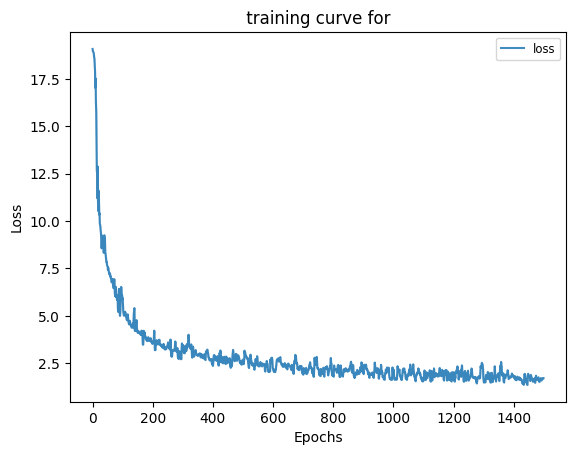

In [18]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [19]:
from kgcnn.molecule.dynamics.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange, CountNodesAndEdges

In [22]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["model_energy"]["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[
        SetRange(node_coordinates="node_coordinates", overwrite=False), 
        CountNodesAndEdges(total_edges="total_ranges", count_edges="range_indices", count_nodes="atomic_number", total_nodes="total_nodes")
    ],  # To use 
    graph_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, energy="energy", force="forces", atomic_number="atomic_number")],
    store_last_input=True,
    update_from_last_input=["range_indices"],  # and "range_images" if periodic.
    update_from_last_input_skip=3,
    use_predict=True
)

In [23]:
dyn_model(dataset[0:510])[0]

{'energy': array([-17470.23185782]),
 'forces': array([[-2.7046587 ,  2.6364074 , -0.83795285],
        [-0.8325118 , -0.8304137 ,  1.9298071 ],
        [ 3.199687  , -2.2114856 , -0.23099986],
        [-0.358469  ,  1.6827395 , -0.14370465],
        [-0.07265449,  1.93453   ,  0.8878544 ],
        [-0.5857882 ,  0.28193653, -0.03827663],
        [ 0.11262894,  0.81686985, -2.1494641 ],
        [-0.3125065 , -1.3342283 , -0.06432725],
        [ 0.45614308,  4.0177765 ,  2.1264944 ],
        [-0.7438163 ,  2.1267123 ,  0.7690803 ],
        [ 1.1796051 , -1.3084872 ,  0.6248276 ],
        [ 0.80697167, -3.9920936 , -2.0925548 ],
        [ 1.7115226 , -1.0597847 , -0.6828503 ],
        [-0.30439276, -0.5977599 ,  0.4771937 ],
        [ 1.1960336 , -1.8830963 ,  1.3786938 ],
        [ 0.08233488,  0.34388638, -0.8804844 ],
        [-1.0936253 ,  0.36818844, -0.17178205],
        [-0.45834112,  0.4771748 , -0.25331378],
        [-0.29425833, -1.0877173 , -0.7123769 ],
        [-0.4580049 , 

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [24]:
from ase import Atoms
from kgcnn.molecule.dynamics.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [25]:
atoms = Atoms(dataset[0]["atomic_number"], positions=dataset[0]["node_coordinates"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [26]:
conv=AtomsToGraphConverter({"atomic_number": "get_atomic_numbers", "node_coordinates": "get_positions"})
conv(atoms)

<MemoryGraphList [{'atomic_number': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'node_coordinates': array([[ 2.15275078, -0.93790121, -0.05378575],
       [ 0.99956719,  1.13262738, -1.67300307],
       [ 2.73218273, -0.44859684, -1.19275553],
       [ 2.14794307,  0.41880283, -2.08405233],
       [-3.15705489,  1.42240939,  0.33067654],
       [ 0.91168856, -0.33727827,  0.29772754],
       [ 0.36105629,  0.72618343, -0.42339745],
       [-0.40166094, -0.12259909,  2.26219435],
       [-2.13128849, -0.48888369, -0.80224462],
       [ 0.29867456, -2.24990948,  1.44246368],
       [ 0.1239993 , -0.83296539,  1.42230211],
       [-2.04596577,  0.64616435, -0.22107209],
       [-0.88096468,  1.36265193, -0.06099633],
       [-0.02472582, -2.46371902,  2.33402192],
       [ 2.47956412, -1.70739289,  0.55101985],
       [ 0.49126967,  1.99943374, -2.09234064],
       [ 3.77819263, -0.85891833, -1.40897491],
       [ 2.75656656,  0.58901616, -2.98423316],
       [

In [27]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [28]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [29]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

{'energy': array(-17470.2318577), 'forces': array([[-2.7046585 ,  2.6364074 , -0.8379524 ],
       [-0.8325124 , -0.8304142 ,  1.9298081 ],
       [ 3.199687  , -2.211486  , -0.23100048],
       [-0.35846972,  1.6827404 , -0.14370513],
       [-0.07265377,  1.9345291 ,  0.8878536 ],
       [-0.58578855,  0.28193668, -0.03827618],
       [ 0.11262906,  0.81687003, -2.1494648 ],
       [-0.31250626, -1.3342286 , -0.06432732],
       [ 0.45614338,  4.017777  ,  2.1264944 ],
       [-0.74381644,  2.126712  ,  0.76908016],
       [ 1.1796044 , -1.3084866 ,  0.6248275 ],
       [ 0.8069709 , -3.9920936 , -2.0925548 ],
       [ 1.7115228 , -1.0597843 , -0.6828505 ],
       [-0.30439302, -0.59776044,  0.4771942 ],
       [ 1.1960332 , -1.8830969 ,  1.3786936 ],
       [ 0.08233452,  0.3438866 , -0.88048416],
       [-1.0936251 ,  0.36818856, -0.17178193],
       [-0.458341  ,  0.47717485, -0.2533145 ],
       [-0.29425833, -1.0877172 , -0.7123769 ],
       [-0.45800483,  0.30924368, -0.5261864

In [30]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.916eV  Ekin = 0.039eV (T=300K)  Etot = -831.877eV
Energy per atom: Epot = -831.920eV  Ekin = 0.046eV (T=356K)  Etot = -831.874eV
Energy per atom: Epot = -831.925eV  Ekin = 0.047eV (T=363K)  Etot = -831.878eV
Energy per atom: Epot = -831.926eV  Ekin = 0.052eV (T=399K)  Etot = -831.875eV
Energy per atom: Epot = -831.905eV  Ekin = 0.050eV (T=384K)  Etot = -831.855eV
Energy per atom: Epot = -831.931eV  Ekin = 0.063eV (T=488K)  Etot = -831.868eV
Energy per atom: Epot = -831.916eV  Ekin = 0.045eV (T=345K)  Etot = -831.872eV
Energy per atom: Epot = -831.931eV  Ekin = 0.059eV (T=459K)  Etot = -831.872eV
Energy per atom: Epot = -831.915eV  Ekin = 0.048eV (T=371K)  Etot = -831.867eV
Energy per atom: Epot = -831.916eV  Ekin = 0.052eV (T=402K)  Etot = -831.864eV
Energy per atom: Epot = -831.927eV  Ekin = 0.055eV (T=426K)  Etot = -831.872eV
Energy per atom: Epot = -831.917eV  Ekin = 0.049eV (T=379K)  Etot = -831.868eV
Energy per atom: Epot = -831.914eV  Ekin = 0.043eV (

In [31]:
calc.model_predictor._last_input;

In [32]:
dyn_model._test_timing(conv(atoms))

0.025625